An implementation of the "sanity check" kernel, in which the feature
vector of a matrix is a collection of topological properties of the matrix,
such as no. of edges, no. of nodes, graph radius, etc. Because of some trouble
I was having with the GitHub code, I reverted to an earlier version of the
`SIRnet` function (given below).

In [2]:
def SIRnet(thetaVec, N, adjMat, initInfected, chainBool, plotChain):
    '''
    +++++++++++++++++++++++++++++++
    SIRnet function: generates a "fuzzy" random walk of a network from a stochastic
        SIR simulation
    +++++++++++++++++++++++++++++++
    thetaVec     -- parameters of SIR model (see function for specifics)
    N            -- no. of infected at which simulation is terminated
    adjMat       -- adjacency matrix of contact network (should be numpy array)
    initInfected -- index of initial node infected (value between 0 and len(adjMat)-1)
    chainBool    -- Boolean variable controlling if the returned adjacency matrix is
                    the size of the original matrix; if true, it will return only the
                    adjacency matrix of the chain
    plotChain    -- do you want to plot the resulting chain?
                    (will only show the graph if chainBool = True)

    Note that we do not keep track of time because N < len(adjMat)
    '''

    beta = thetaVec[0] # probability of transmission assuming 1 contact
    gamma = thetaVec[1] # recovery rate

    if N > len(adjMat):
        print("ERROR: number of infected must be less than size of adjacency matrix!")
        return

    successBool = False
    # make sure we return subgraph of length w/N nodes
    while not successBool:
        infCount = 1

        # arrays containing total and infected populations
        NVec = np.array(range(len(adjMat))) # total no. of nodes
        infVec = np.array([np.random.choice(range(len(adjMat)))], dtype = int)
        recVec = [] # empty array

        while (infCount < N) & (infCount > 0):

            # update susceptible pop. array
            deleteVec = np.sort(np.concatenate((infVec,recVec)))
            deleteVec = deleteVec.astype(int)
            susVec = np.delete(NVec, deleteVec)

            # calculate rates of new infections/recoveries
            atRiskSus = np.sum(adjMat[infVec,:], axis=0) # at-risk susceptibles
            atRiskSus = np.where(atRiskSus > 0)
            # take the intersect of at-risk susceptibles and susceptibles
            atRiskSus = np.intersect1d(susVec, atRiskSus)
            rateS2I = beta*len(atRiskSus)

            rateI2R = gamma*len(infVec)

            # Gillespie algorithm but w/o time
            totalRate = rateS2I + rateI2R
            rateS2I = rateS2I / totalRate
            rateI2R = rateI2R / totalRate

            tmpRand = np.random.uniform()
            if tmpRand <= rateS2I:
                # a random susceptible becomes infected
                infVec = np.sort(np.append(infVec, np.random.choice(atRiskSus, 1)))
                infCount += 1
            else:
                # an infected individual recovers
                tmpInd = np.random.choice(len(infVec))
                recVec = np.append(recVec, infVec[tmpInd])
                infVec = np.delete(infVec, tmpInd)
                infCount -= 1
                ## end of if statement
            ## end of while loop

        if infCount == N:
            successBool = True
            contactVec = np.sort(np.concatenate((infVec, recVec)))
            contactVec = contactVec.astype(int)

            # prune the adjacency matrix so it only contains connections to infected nodes
            keepMeMat = np.zeros((len(adjMat),len(adjMat)))
            keepMeMat[contactVec,:] = 1
            keepMeMat[:,contactVec] = 1
            infAdjMat = np.multiply(keepMeMat, adjMat)

            # only useful for plotting
            if plotChain:
                # plot the chain
                colorVec = np.array(['green']*len(infAdjMat))
                colorVec[contactVec.astype(int)] = 'red'

            if chainBool:
                # return only the chain
                idxCols = np.argwhere(np.all(infAdjMat[..., :] == 0, axis=0))
                idxRows = np.argwhere(np.all(infAdjMat[..., :] == 0, axis=1))
                infAdjMat = np.delete(infAdjMat, idxCols, axis=1)
                infAdjMat = np.delete(infAdjMat, idxRows, axis=0)
                if plotChain:
                    # plot the chain
                    colorVec = np.delete(colorVec, idxCols)
                    nx.draw_spring(nx.from_numpy_matrix(infAdjMat), node_color=colorVec)
                    plt.show()

            # print("Shape: ", infAdjMat.shape)
            # print("Chain: ", infAdjMat)
        else:
            successBool = False

    ## end of while successBool loop
    return infAdjMat

Next, a revised version of the `GetSimulatedData` function from the GitHub.
The most significant difference b/w earlier versions is that this one (1) ensures
the graph is connected before being used as training data, and (2) uses random
graph generation parameter values. The former change was to prevent hang ups with the
SIR code, while the latter tests the robustness of the naive classifier.

Even though the parameters for the graph generations are not realistic, they are
mainly so that the SVM can learn the full breadth of topological possibilities for
each graph class. Probabilities for the E-R graphs are limited above by 90% to
discern them sufficiently from complete graphs.


In [119]:
import numpy as np
import random

def GetSimulatedData(num_samples, models, network_size, sir_params, infection_cutoff):
    x_adjMat= []
    y_network = []
    num_models = len(models)

    for j in range(num_models):
        network_type = models[j]
        for i in range(int(num_samples/num_models)):
            # print(i)
            if network_type.lower()=="small worlds":
                graph = nx.watts_strogatz_graph(network_size, random.randint(1,10)*2,
                                                np.random.uniform())
                while (not nx.is_connected(graph)):
                    graph = nx.watts_strogatz_graph(network_size, random.randint(1,10)*2,
                                                    np.random.uniform())
            elif network_type.lower()=="erdos renyi":
                # the upper bound is set to 10%
                graph = nx.fast_gnp_random_graph(network_size,
                                                 np.random.uniform(high=0.9))
                while (not nx.is_connected(graph)):
                    graph = nx.fast_gnp_random_graph(network_size,
                                                     np.random.uniform(high=0.9))
            elif network_type.lower()=="complete":
                graph = nx.erdos_renyi_graph(network_size, 1)
            elif network_type.lower() == "scale-free":
                graph = nx.barabasi_albert_graph(network_size, random.randint(1,20))

            # #Draw Adjacency matrix
            ad_mat = nx.linalg.graphmatrix.adjacency_matrix(graph).toarray()
            # #Simulate infection
            # NOTE: chainBool is set to True since we only want the infected "chain"
            # and their connections
            ad_mat =SIRnet(sir_params,infection_cutoff*network_size, ad_mat, 0,
                           True, False)

            # x_adjMat.append(ad_mat)
            # extract feature vector
            fv = np.zeros(5)
            # no. of edges
            fv[0] = sum(sum(ad_mat))/2
            # no. of nodes
            fv[1] = len(ad_mat)
            # max. degree
            fv[2] = max(sum(ad_mat))
            # avg. degree
            fv[3] = np.mean(sum(ad_mat))
            # convert to networkx graph
            x1tmp = nx.from_numpy_array(ad_mat)
            # radius of graph
            fv[4] = nx.radius(x1tmp)

            # keeping the notation the same here, even though we're not
            # working with adjacency matrices
            x_adjMat.append(fv)
            y_network.append(network_type.lower())

    # save data
    np.savez("C:/Users/cole/OneDrive/Dropbox_new/BMA_790_final_project/data/test_data.npz",
             x_adjMat = x_adjMat, y_network= y_network)

The following is just a chunk of code to see how the data looks. This was also
to make sure the SIR code was behaving.

0.0881190121826354


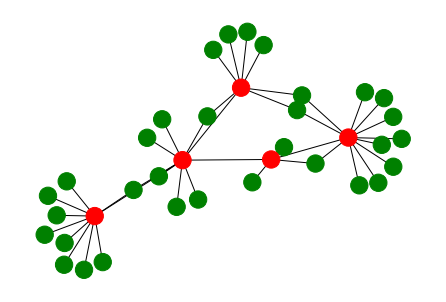

In [120]:
# generate some data to check my sanity...
testVal = np.random.uniform(high=0.1)
graph = nx.fast_gnp_random_graph(network_size,
                                 testVal)
while (not nx.is_connected(graph)):
    testVal = np.random.uniform(high=0.1)
    graph = nx.fast_gnp_random_graph(network_size,
                                     testVal)
print(testVal)
ad_mat = nx.linalg.graphmatrix.adjacency_matrix(graph).toarray()
# #Simulate infection
ad_mat =SIRnet(np.array([0.5,0.1]),5, ad_mat, 0,
               True, True)

Now generate the test data, load it in, and perform the fit.

In [136]:
# load packages
import sys
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

#Load Functions
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#----------------Generate test data---------------------
models= ["small worlds", "erdos renyi", "complete", "scale-free"]
# this was reduced just in case it was contributing to improved classification
# (classification actually improves as this increases)
network_size=100
sir_params= np.array([0.5, 0.1])
infection_cutoff=(5/500)
GetSimulatedData(1000, models, network_size, sir_params, infection_cutoff)
#----------------Load test data---------------------
data=np.load("C:/Users/cole/OneDrive/Dropbox_new/BMA_790_final_project/data/test_data.npz", allow_pickle=True)
print(data.files)

['x_adjMat', 'y_network']


Just a sanity check...

In [137]:
x_data = data["x_adjMat"]
y_data = data["y_network"]
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size = 0.3)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(700, 5)
(700,)
(300, 5)
(300,)


Now fit the model on the training data and see how it does on the testing data.

In [139]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix as cm

#----------------Define Global Parameters---------------------
# data_filename='../data/full_data.npz'
# I used a 70/30 training/testing split since it's lightning fast
test_train_split = .3

# some suggested C values I found on the internet...
c_vec = 2.0**(np.arange(-2,2)) # np.array([10,20,30,40,50])
#----------------Load Data------------------------------------
#unpack npz file
# data=np.load(data_filename, allow_pickle=True)
#seperate adjacency matrices and network type
x_data = data["x_adjMat"]
y_data = data["y_network"]
#Split into Test/ Train
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,
                                                    test_size = test_train_split)
print(x_train.shape)
print(y_train[0:20])
# where the magic happens
naiveSVM = SVC(kernel='linear', C=c_vec[0])
naiveSVM.fit(x_train, y_train)
print(naiveSVM.score(x_test,y_test))
y_pred = naiveSVM.predict(x_test)

# a cheap form of PCA to identify the most influential predictor
# naiveSVM.fit(np.delete(x_train,4,axis=1), y_train)
# naiveSVM.score(np.delete(x_test,4,axis=1),y_test)

# and now a confusion matrix...
print(cm(y_test, y_pred,
         labels=["scale-free","erdos renyi","complete","small worlds"]))

(700, 5)
['small worlds' 'erdos renyi' 'complete' 'small worlds' 'scale-free'
 'scale-free' 'complete' 'erdos renyi' 'scale-free' 'erdos renyi'
 'scale-free' 'small worlds' 'erdos renyi' 'scale-free' 'erdos renyi'
 'erdos renyi' 'complete' 'scale-free' 'small worlds' 'small worlds']
0.9466666666666667
[[69  1  0  4]
 [ 1 76  0  3]
 [ 0  0 71  0]
 [ 7  0  0 68]]


Make a 2D plot of the data according to the two most influential predictors.

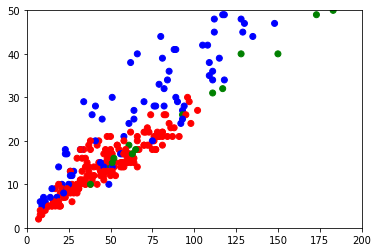

In [140]:
import matplotlib.colors as mc
# generate a plot of the data
xVec = x_train[:,1]
yVec = x_train[:,2]

colorVec = y_train
colors = ["red", "blue", "green", "purple"]
colorVec[colorVec == "small worlds"] = 0
colorVec[colorVec == "scale-free"] = 1
colorVec[colorVec == "erdos renyi"] = 2
colorVec[colorVec == "complete"] = 3

colormap = mc.ListedColormap(colors)

# using two predictors, let's see how they look
plt.scatter(xVec, yVec, c=colorVec.astype(int), cmap=colormap)
plt.xlim(0,200)
plt.ylim(0,50)
plt.show()

# plt.savefig("graph_plot.png")

In [ ]:
c_vec = np.array([10,20,30,40,50])
for iC in range(len(c_vec)):
    # define SVC with precomputed kernel
    model = SVC(kernel= "precomputed", C=c_vec[iC],  random_state=0)
    # fit model
    print("Fitting model")
    model.fit(kernel_train,y_train)
    # test accuracy
    print("Testing model")
    accuracy = model.score(kernel_test,y_test)
    if accuracy >= accuracy_best:
        y_pred = model.predict(kernel_test)
        confmatrix = confusion_matrix(y_pred, y_test,
                                      labels=["small worlds", "scale-free", "complete", "erdos renyi"])
        confmatrix = confmatrix#/(confmatrix.sum(axis=1)+.001)
    accuracies[iC]=accuracy

print(accuracies)
print(y_test[0:20])
print(y_pred[0:20])
print(confmatrix)


Fitting model
Testing model
Fitting model
Testing model
Fitting model
